# **Convolutional Neural Network (CNN)**

### **1. Imports**

In [1]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

# checking verions
import sys
print(sys.version) # python
print(torch.__version__)
print(torchvision.__version__)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
2.2.1+cu121
0.17.1+cu121


### **2. Manual Seed**


In [2]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

### **3. DataSets(`FashionMNIST`)**

In [3]:
# FashionMNIST
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26421880/26421880 [00:14<00:00, 1879457.17it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299200.69it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 762006.98it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5100939.52it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### **4. Checking `Shape`/`Size`**





In [4]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [5]:
# Access the first element of train_data
train_data[0]

# Unpack the first element of train_data into `image` and `label` variables
image, label = train_data[0]

# Print the shape of the image tensor
print(image.shape)

# NOTE: It does not remove the color channel
# Removes any single-dimensional entries from the shape of the image tensor
print(image.squeeze().shape)

# Adding a new dimension at dim=0 (batch dimension)
print(image.unsqueeze(dim=0).shape)

# Print the label associated with the image
print(label)

torch.Size([1, 28, 28])
torch.Size([28, 28])
torch.Size([1, 1, 28, 28])
9


In [6]:
class_names = train_data.classes
print(class_names)

class_to_idx = train_data.class_to_idx
print(class_to_idx)

print(train_data.targets)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
tensor([9, 0, 0,  ..., 3, 0, 5])


### **5. Visualizing the data Sample**

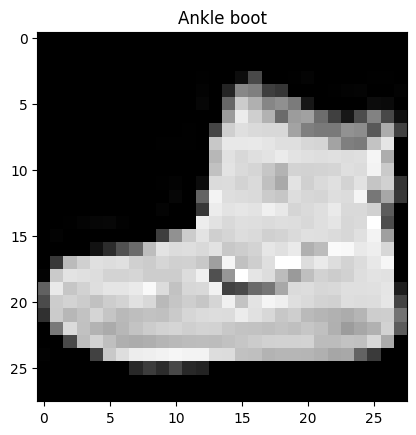

In [7]:
# Ploting the single sample
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.show()

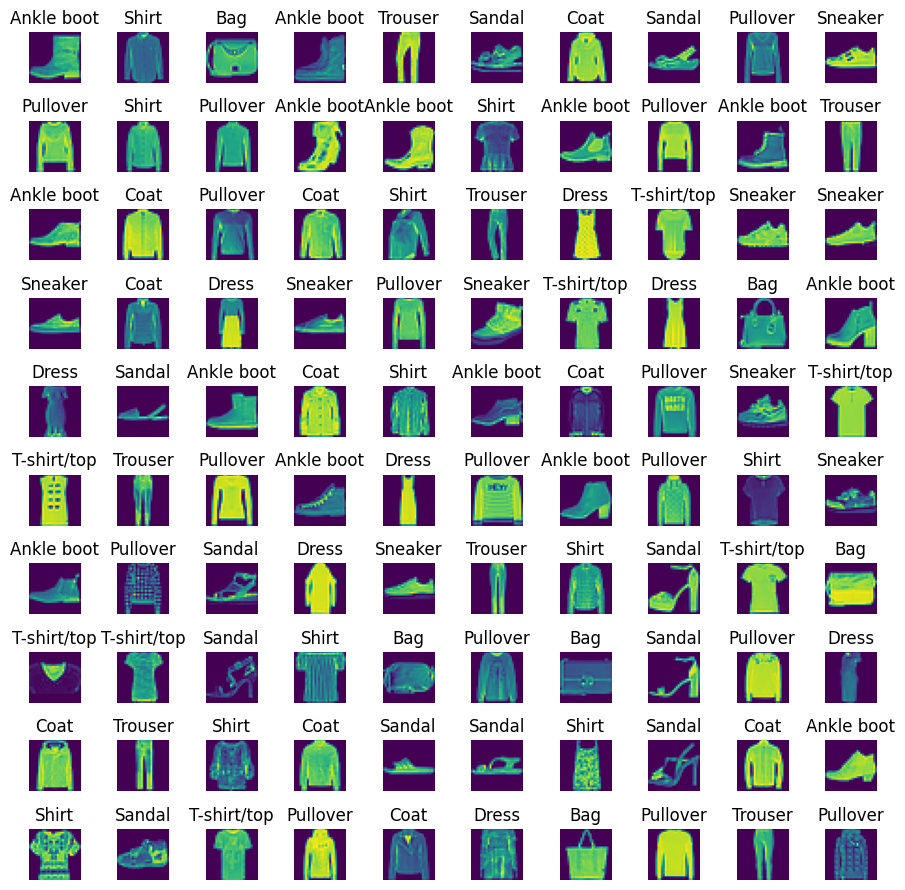

In [8]:
# Plotting the grid of samples
fig = plt.figure(figsize=(9, 9))

rows, cols = 10, 10
# Loop for generating and plotting 16 random samples
for i in range(1, (rows*cols+1)):        # Range adjusted to generate 16 samples (4x4 grid)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_idx]
    ax = fig.add_subplot(rows, cols, i)  # Subplot index starts from 1
    ax.imshow(image.squeeze())
    ax.set_title(class_names[label])
    ax.axis('off')                       # Turning off axis labels
plt.tight_layout()                       # Adjusting layout for better display
plt.show()

### **6. DataLoader**

- `batching`
- `shuffling`
- `parallelism`
- `data transformations`
- `prefetching`
- `iterable interface`

In [9]:
BATCH_SIZE = 32  # Define the batch size for training and testing data

# Create a DataLoader for the training data
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True  # Shuffle the data for better training
)

# Create a DataLoader for the testing data
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False  # No need to shuffle the testing data
)

### **7. Device agnostic**

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### **8. Model**

In [11]:
# Creat the CNN model:
# Create a convolutional neural network
class FashionMNISTModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
            )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

model = FashionMNISTModel(
    input_shape=1,
    hidden_units=10,
    output_shape= len(class_names)).to(device)

print(model)

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


```markdown
Input: [batch_size, 1, 28, 28]
|
|--- Conv2d: [batch_size, 10, 28, 28]
|    |--- ReLU
|    |--- Conv2d: [batch_size, 10, 28, 28]
|    |    |--- ReLU
|    |    |--- MaxPool2d: [batch_size, 10, 14, 14]
|
|--- Conv2d: [batch_size, 10, 14, 14]
|    |--- ReLU
|    |--- Conv2d: [batch_size, 10, 14, 14]
|    |    |--- ReLU
|    |    |--- MaxPool2d: [batch_size, 10, 7, 7]
|
|--- Flatten: [batch_size, 490] ~ (batch_size*7*7)
|--- Linear: [batch_size, n] (where n is the number of classes)

```

$$O=\frac{n-f+2p}{s}+1$$

where:
- `n` $\rightarrow$ is the `input` height/width,
- `f` $\rightarrow$ is the `filter` (kernel) size,
- `p` $\rightarrow$ is the `padding`
- `s` $\rightarrow$ is the `stride`.
- `O` $\rightarrow$ is `output` layer shape



In [12]:
# Testing the model on the random image tensor
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

# Pass image through model
# It will output the  raw logits (scores) for different classes.
# To interpret them as probabilities, apply the softmax function.
model(rand_image_tensor.unsqueeze(0).to(device))

tensor([[-0.0907, -0.0290,  0.0707,  0.0100,  0.0387, -0.0164,  0.0662,  0.0127,
          0.0291, -0.0787]], grad_fn=<AddmmBackward0>)

In [ ]:
# stepping through the Conv2d
ra

**Here’s why `model.state_dict()` is crucial:**

- **Modularity:** It allows for the easy saving, updating, altering, and restoring of model parameters, which adds a great deal of flexibility and modularity to PyTorch models and optimizers.

- **Checkpointing:** It is used for saving or loading models, which is particularly useful when you need to continue training from a specific point or want to share the model with others.

- **Transfer Learning:** When you want to use the model parameters as a starting point for training on a new task (transfer learning), `model.state_dict()` makes it easy to load the pre-trained parameters.